# Classification of Sorted Hands of Cards using the 'Abstracter' Model

In [1]:
%%capture
!git clone https://github.com/jdlafferty/relational.git
!git checkout awni-debugging
%cd relational

!pip install pydealer
!pip install wandb

In [2]:
import pydealer
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.metrics

from hand2hand import Cards
import utils

In [3]:
%env "WANDB_NOTEBOOK_NAME" "Abstracter Hand Classifier.ipynb"

import wandb
wandb.login()

env: "WANDB_NOTEBOOK_NAME"="Abstracter Hand Classifier.ipynb"


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# utility functions

card_image_shape = (178, 122, 3)
hand_size = 7
class_names = ['not sorted', 'sorted']

def create_callbacks(monitor='loss', log_gradients=False, save_model=True, log_weights=True,
                     train_ds=None, val_ds=None, ):
    callbacks = [
#         tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='auto', restore_best_weights=True),
#         tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto'),
#         wandb.keras.WandbMetricsLogger(log_freq='epoch'),
#         wandb.keras,WandbModelCheckpoint(monitor='loss', mode='auto', save_freq='epoch')
        wandb.keras.WandbCallback(
            monitor=monitor, log_weights=log_weights, log_gradients=log_gradients, save_model=save_model, save_graph=True,
            training_data=train_ds, validation_data=val_ds,
            labels=class_names, predictions=64, compute_flops=True)
        ]
    return callbacks

metrics = [
        tf.keras.metrics.BinaryAccuracy(name='acc'),
        tf.keras.metrics.Precision(class_id=1, name='precision'),
        tf.keras.metrics.Recall(class_id=1, name='recall'),
        tf.keras.metrics.AUC(curve='ROC', multi_label=True, name='auc')
        ]

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
opt = tf.keras.optimizers.Adam()

def get_preds(model, ds, print_classification_report=True):
    y_pred_proba = model.predict(ds.batch(128))
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.array([y for x,y in ds])
    if print_classification_report:
        print(sklearn.metrics.classification_report(y_true[:,1], y_pred))

    return y_true, y_pred_proba, y_pred

def log_to_wandb(y_test, pred_proba_test, pred_test):
    # log test-set metrics to W&B
    y_test = np.array(y_test[:,1])
    wandb.log({"pr": wandb.plot.pr_curve(y_test, pred_proba_test, class_names)})
    wandb.log({"roc": wandb.plot.roc_curve(y_test, pred_proba_test, labels=class_names)})
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(y_true=y_test, preds=pred_test, class_names=class_names)})

def wrap_run(model, ds):
    y_true, y_pred_proba, y_pred = get_preds(model, ds, print_classification_report=True)
    log_to_wandb(y_true, y_pred_proba, y_pred)
    wandb.finish()

# Defining 'Abstracter' Model

In this section, we define the different components of the Abstracter model. (A few minor modifications are made to the implementation in `seq2seq_transformer.py`). In particular, we implement the following layers:

- `AddPositionalEmbedding`: Here, I define a layer which only adds a positional encoding, without embedding tokens. Rather than expecting a sequence of tokens as input, it expects a sequence of vectors, and simply adds a positional encoding to each vector elemntwise in the sequence. Just defining this to separate out the 'token embedding' and 'positional encoding' steps in the model since if the input sequence is (for e.g.) a sequence of images rather than a sequence of tokens, we would need to embed them differently, but still need to add a positional embedding.

- `Encoder`: Exactly the same implementation as `seq2seq_transformer.py`, except I'm removing the part of the layer that embeds the sequence and adds a positional embedding (just to separate out the computations a bit more to make things more modular).

- `EpisodicDecoder`: Just changed the implementation so that the input sequence vector parameters are explicitly a parameter of the model (so that we don't have to pass in a fixed one-hot vector sequence as input to achieve the desired effect, this is now built in). Also added option to turn off adding positional encoding.

In [5]:
import seq2seq_transformer
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model, Sequential
from seq2seq_transformer import (EncoderLayer, DecoderLayer, positional_encoding, EpisodicDecoderLayer,
                                 BaseAttention, GlobalSelfAttention, FeedForward)

In [6]:
# define non-token positional embedding layer (for vector input; just adds positional embedding)
# defining this to separate the 'adding positional embedding' from the 'token embedder' steps

class AddPositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, name='add_positional_embedding'):
        super().__init__(name=name)

    def build(self, input_shape):
        _, self.seq_length, self.vec_dim = input_shape
        # compute fixed positional encoding to be added
        # TODO: why length=2048 and not seq_length?
        self.pos_encoding = positional_encoding(length=2048, depth=self.vec_dim)

    def call(self, x):
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.vec_dim, tf.float32))

        # add positional encoding
        x = x + self.pos_encoding[tf.newaxis, :self.seq_length, :] # NOTE: see build

        return x

In [7]:
# TODO: name something else? more specific name? e.g.: AbstracterEncoder/TransformerEncoder/...

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, num_heads,
               dff, dropout_rate=0.1, name='encoder'):

        super().__init__(name=name)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.dff = dff
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
    
        _, self.sequence_length, self.d_model = input_shape

        self.enc_layers = [
            EncoderLayer(d_model=self.d_model,
                         num_heads=self.num_heads,
                         dff=self.dff,
                         dropout_rate=self.dropout_rate)
            for _ in range(self.num_layers)
            ]

        self.dropout = tf.keras.layers.Dropout(self.dropout_rate)

    
    def call(self, x):
        # `x` is shape: (batch, seq_len, vec_dim)

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`

In [8]:
# Original Episodic Decoder with Q=E, K=E, V=D
class EpisodicDecoder(tf.keras.layers.Layer):
    """
    The 'Decoder' of the 'Abstracter' Model.
    
    Based on the Transformer's decoder, except with the modification that
    the queries and keys now both come from the encoder, and the values come
    from the decoder. The input at the decoder is now a learned parameter.
    """
    def __init__(self, num_layers, num_heads, dff, use_pos_embedding=True,
               dropout_rate=0.1, name='episodic_decoder'):
        super(EpisodicDecoder, self).__init__(name=name)
        
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.dff = dff
        self.use_pos_embedding = use_pos_embedding
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        
        _, self.sequence_length, self.d_model = input_shape

        # define the input-independent symbolic input vector sequence at the decoder
        normal_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
        self.decoder_symbol_sequence = tf.Variable(
            normal_initializer(shape=(self.sequence_length, self.d_model)),
            trainable=True)

        # layer which adds positional embedding (to be used on symbol sequence)
        if self.use_pos_embedding:
            self.add_pos_embedding = AddPositionalEmbedding()
        
        self.dropout = tf.keras.layers.Dropout(self.dropout_rate)
    
        self.dec_layers = [
            EpisodicDecoderLayer(d_model=self.d_model, num_heads=self.num_heads,
                         dff=self.dff, dropout_rate=self.dropout_rate)
            for _ in range(self.num_layers)]

        self.last_attn_scores = None

    def call(self, encoder_context):
        # symbol sequence is input independent, so use the same one for all computations in the given batch
        symbol_seq = tf.zeros_like(encoder_context) + self.decoder_symbol_sequence
    
        # add positional embedding
        if self.use_pos_embedding:
            symbol_seq = self.add_pos_embedding(symbol_seq)

        symbol_seq = self.dropout(symbol_seq)

        for i in range(self.num_layers):
            symbol_seq = self.dec_layers[i](symbol_seq, encoder_context)

#             self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        return symbol_seq

## Build Card Image Encoder via Training on Card Classification Task

Here, we build an encoder for our relational model(s) by training on another task. In particular, we train a CNN model which classifies the card from its image. From this we will use the intermediate encoder inside this model as well as the full classifier as encoders for our input sequence in the relational model. 

In [9]:

# create card classification dataset
card_rank_dict = pydealer.DEFAULT_RANKS['values']
card_suit_dict = pydealer.DEFAULT_RANKS['suits']

def card_classification_generator():
    deck = Cards()
    pydeck = pydealer.Deck()

    for card in pydeck:
        x = deck.image_of_pycard(card) / 255
        y = deck.index_of_card(card)
        yield x,y

card_classification_ds = tf.data.Dataset.from_generator(
     card_classification_generator,
     output_signature=(
         tf.TensorSpec(shape=card_image_shape, dtype=tf.float32),
         tf.TensorSpec(shape=(), dtype=tf.int32))
    )


In [10]:
img_input = layers.Input(shape=card_image_shape, name='card_image')

x = layers.Conv2D(32, (5, 5), activation='relu')(img_input)
x = layers.MaxPooling2D((4,4))(x)
x = layers.Conv2D(32, (5, 5), activation='relu')(x)
x = layers.MaxPooling2D((4,4))(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)

card_encoder = Model(inputs=img_input, outputs=x, name='card_encoder')
card_classification = layers.Dense(52, name='card_classification')(card_encoder(img_input))

cnn_card_clf = Model(inputs=img_input, outputs=card_classification, name='card_cnn')

cnn_card_clf.summary()

cnn_card_clf.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     metrics=['accuracy'])

Model: "card_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
card_image (InputLayer)      [(None, 178, 122, 3)]     0         
_________________________________________________________________
card_encoder (Functional)    (None, 64)                138720    
_________________________________________________________________
card_classification (Dense)  (None, 52)                3380      
Total params: 142,100
Trainable params: 142,100
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = cnn_card_clf.fit(card_classification_ds.batch(52), epochs=50, verbose=0)

2023-01-03 22:04:07.383951: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-03 22:04:08.873698: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


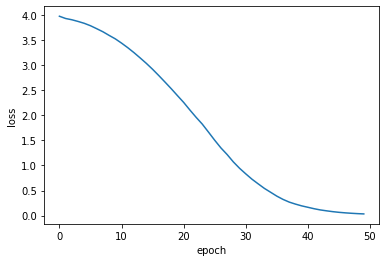

In [12]:
plt.plot(history.history['loss']);
plt.xlabel('epoch'); plt.ylabel('loss');

## Hand Classification Datasets: Tokenized Input and Image Input

In this section, we define the hand classification datasets. We define two datasets. In one, the input sequence is a sequence of tokens with a vocab size of 52. In the other, the input sequence is a sequence of images. The datasets are generated dynamically by defining a 'generator' and using the tensorflow data API. This means that when no seed is specified, the training dataset will be different at each epoch (since the generation process involves randomness). When a seed is specified, the data generated is repeatable.

In [13]:
# create 'toy' dataset where the cards in the input sequence are represented as an index in a vocab of length 52 

train_size = 10000

def create_tokenized_hand_clf_ds(seed=None, train_size=train_size):
    

    def tokenized_hand_clf_ds_generator():
        np.random.seed(seed) # optionally set seed for repeatability if desired

        deck = Cards()
        pydeck = pydealer.Deck()
        pydeck.shuffle()

        for i in np.arange(train_size):
            hand = pydeck.deal(hand_size)
            if len(hand) < hand_size:
                # ran out of cards, make a new deck
                pydeck = pydealer.Deck()
                pydeck.shuffle()
                hand = pydeck.deal(hand_size)
            if np.random.normal() < 0:
                deck.sort_pyhand(hand)

            x = deck.index_pyhand(hand)
            y = deck.is_sorted_pyhand(hand)
            yield x, y

    ds = tf.data.Dataset.from_generator(
         tokenized_hand_clf_ds_generator,
         output_signature=(
             tf.TensorSpec(shape=(hand_size, ), dtype=tf.int32),
             tf.TensorSpec(shape=(), dtype=tf.int32))
        )

    ds = ds.map(lambda x,y: (x, tf.one_hot(y,2)))
    
    return ds

In [14]:
# define dataset generator for sequence of card images

def create_img_hand_clf_ds(seed=None, train_size=train_size):
    
    
    def hand_classification_generator():
        np.random.seed(seed) # set seed for reproducibility of results

        deck = Cards()
        pydeck = pydealer.Deck()
        pydeck.shuffle()

        for i in np.arange(train_size):
            hand = pydeck.deal(hand_size)
            if len(hand) < hand_size:
                # ran out of cards, make a new deck
                pydeck = pydealer.Deck()
                pydeck.shuffle()
                hand = pydeck.deal(hand_size)
            if np.random.normal() < 0:
                deck.sort_pyhand(hand)

            x = np.array([deck.image_of_pycard(hand[j]) / 255 for j in range(hand_size)])
            y = deck.is_sorted_pyhand(hand)
            yield x,y

    ds = tf.data.Dataset.from_generator(
         hand_classification_generator,
         output_signature=(
             tf.TensorSpec(shape=(hand_size, *card_image_shape), dtype=tf.float32),
             tf.TensorSpec(shape=(), dtype=tf.int32))
        )
    
    ds = ds.map(lambda x,y: (x, tf.one_hot(y,2)))
    
    return ds

## RNN Model (Reference)

A simple GRU RNN model for reference. Tested with token input, and two variants of the card image encoder.

### Token Input

In [15]:
hand_input = layers.Input(shape=(hand_size, ))
x = layers.Embedding(52, 32, name='token_embedding')(hand_input)
x = layers.GRU(64, name='gru_rnn')(x)
x = layers.Dense(2, activation='softmax', name='output')(x)
rnn_clf = Model(hand_input, x, name='rnn_clf')
rnn_clf.summary()
rnn_clf.compile(loss=loss, optimizer=opt, metrics=metrics)

Model: "rnn_clf"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
token_embedding (Embedding)  (None, 7, 32)             1664      
_________________________________________________________________
gru_rnn (GRU)                (None, 64)                18816     
_________________________________________________________________
output (Dense)               (None, 2)                 130       
Total params: 20,610
Trainable params: 20,610
Non-trainable params: 0
_________________________________________________________________


In [16]:
train_ds = create_tokenized_hand_clf_ds(seed=None)

run = wandb.init(project='Abstracter Hand Classification', group='RNN (Token Inputs)', save_code=True)

history = rnn_clf.fit(train_ds.batch(256), epochs=5, callbacks=create_callbacks(save_model=False))

wandb: Currently logged in as: awni00. Use `wandb login --relogin` to force relogin


2023-01-03 22:04:39.124990: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 22:04:39.125533: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-01-03 22:04:39.125728: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2023-01-03 22:04:39.126503: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 22:04:39.126987: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 22:04:39.127465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

Epoch 1/5
40/40 [==============================] - 8s 90ms/step - loss: 0.6253 - acc: 0.7466 - precision: 0.7862 - recall: 0.6633 - auc: 0.8543
Epoch 2/5
40/40 [==============================] - 4s 102ms/step - loss: 0.2217 - acc: 0.9204 - precision: 0.8825 - recall: 0.9728 - auc: 0.9793
Epoch 3/5
40/40 [==============================] - 4s 93ms/step - loss: 0.0956 - acc: 0.9710 - precision: 0.9555 - recall: 0.9875 - auc: 0.9932
Epoch 4/5
40/40 [==============================] - 4s 95ms/step - loss: 0.0748 - acc: 0.9769 - precision: 0.9651 - recall: 0.9899 - auc: 0.9956
Epoch 5/5
40/40 [==============================] - 4s 97ms/step - loss: 0.0616 - acc: 0.9820 - precision: 0.9722 - recall: 0.9922 - auc: 0.9964


In [17]:
test_ds = create_tokenized_hand_clf_ds(seed=42)
rnn_clf.evaluate(test_ds.batch(256), return_dict=True);
wrap_run(rnn_clf, test_ds)

40/40 [==============================] - 5s 94ms/step - loss: 0.0599 - acc: 0.9805 - precision: 0.9652 - recall: 0.9970 - auc: 0.9962
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      4991
         1.0       0.97      1.00      0.98      5009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



acc,▁▆███
auc,▁▇███
epoch,▁▃▅▆█
loss,█▃▁▁▁
precision,▁▅▇██
recall,▁████
GFLOPS,0.0
acc,0.982
auc,0.99639
best_epoch,4
best_loss,0.06163


### Full Card Classifier as Encoder

In [18]:
hand_input = layers.Input(shape=(hand_size, *card_image_shape))
x = layers.TimeDistributed(cnn_card_clf, name='card_clf_encoder', trainable=False)(hand_input)
x = layers.GRU(64, name='gru_rnn')(x)
x = layers.Dense(2, activation='softmax', name='output')(x)
rnn_clf = Model(hand_input, x, name='rnn_clf')
rnn_clf.summary()
rnn_clf.compile(loss=loss, optimizer=opt, metrics=metrics)

Model: "rnn_clf"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 7, 178, 122, 3)]  0         
_________________________________________________________________
card_clf_encoder (TimeDistri (None, 7, 52)             142100    
_________________________________________________________________
gru_rnn (GRU)                (None, 64)                22656     
_________________________________________________________________
output (Dense)               (None, 2)                 130       
Total params: 164,886
Trainable params: 22,786
Non-trainable params: 142,100
_________________________________________________________________


In [19]:
train_ds = create_img_hand_clf_ds(seed=None)

run = wandb.init(project='Abstracter Hand Classification', group='RNN (Image Inputs, Clf Encoder)', save_code=True)

history = rnn_clf.fit(train_ds.batch(256), epochs=5, callbacks=create_callbacks(save_model=False))

2023-01-03 22:05:49.643344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 22:05:49.643869: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-01-03 22:05:49.644065: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2023-01-03 22:05:49.644893: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 22:05:49.645426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 22:05:49.645895: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

Epoch 1/5


2023-01-03 22:05:54.518663: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


40/40 [==============================] - 31s 655ms/step - loss: 0.4512 - acc: 0.8832 - precision: 0.8688 - recall: 0.9034 - auc: 0.9593
Epoch 2/5
40/40 [==============================] - 21s 522ms/step - loss: 0.2679 - acc: 0.9034 - precision: 0.8822 - recall: 0.9312 - auc: 0.9621
Epoch 3/5
40/40 [==============================] - 21s 522ms/step - loss: 0.1629 - acc: 0.9431 - precision: 0.9205 - recall: 0.9703 - auc: 0.9872
Epoch 4/5
40/40 [==============================] - 21s 516ms/step - loss: 0.0966 - acc: 0.9708 - precision: 0.9565 - recall: 0.9869 - auc: 0.9949
Epoch 5/5
40/40 [==============================] - 21s 517ms/step - loss: 0.0678 - acc: 0.9804 - precision: 0.9693 - recall: 0.9922 - auc: 0.9971


In [20]:
test_ds = create_img_hand_clf_ds(seed=42)
rnn_clf.evaluate(test_ds.batch(256), return_dict=True);
wrap_run(rnn_clf, test_ds)

40/40 [==============================] - 22s 529ms/step - loss: 0.0587 - acc: 0.9808 - precision: 0.9656 - recall: 0.9972 - auc: 0.9979
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      4991
         1.0       0.97      1.00      0.98      5009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



acc,▁▂▅▇█
auc,▁▂▆██
epoch,▁▃▅▆█
loss,█▅▃▂▁
precision,▁▂▅▇█
recall,▁▃▆██
GFLOPS,0.5252
acc,0.9804
auc,0.99711
best_epoch,4
best_loss,0.06779


### Classifier's Intermediate Encoder as Card Encoder

In [21]:
hand_input = layers.Input(shape=(hand_size, *card_image_shape))
x = layers.TimeDistributed(card_encoder, name='card_encoder', trainable=False)(hand_input)
x = layers.GRU(64, name='gru_rnn')(x)
x = layers.Dense(2, activation='softmax', name='output')(x)
rnn_clf = Model(hand_input, x, name='rnn_clf')
rnn_clf.summary()
rnn_clf.compile(loss=loss, optimizer=opt, metrics=metrics)

Model: "rnn_clf"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 7, 178, 122, 3)]  0         
_________________________________________________________________
card_encoder (TimeDistribute (None, 7, 64)             138720    
_________________________________________________________________
gru_rnn (GRU)                (None, 64)                24960     
_________________________________________________________________
output (Dense)               (None, 2)                 130       
Total params: 163,810
Trainable params: 25,090
Non-trainable params: 138,720
_________________________________________________________________


In [22]:
train_ds = create_img_hand_clf_ds(seed=None)

run = wandb.init(project='Abstracter Hand Classification', group='RNN (Image Inputs, Intermediate Encoder)', save_code=True)

history = rnn_clf.fit(train_ds.batch(256), epochs=5, callbacks=create_callbacks(save_model=False))

2023-01-03 22:10:48.209666: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 22:10:48.210155: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-01-03 22:10:48.210343: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2023-01-03 22:10:48.211244: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 22:10:48.211786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 22:10:48.212277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

Epoch 1/5
40/40 [==============================] - 30s 660ms/step - loss: 0.5316 - acc: 0.8618 - precision: 0.8449 - recall: 0.8832 - auc: 0.9447
Epoch 2/5
40/40 [==============================] - 20s 502ms/step - loss: 0.3766 - acc: 0.8454 - precision: 0.8346 - recall: 0.8669 - auc: 0.9192
Epoch 3/5
40/40 [==============================] - 21s 517ms/step - loss: 0.2725 - acc: 0.9034 - precision: 0.8811 - recall: 0.9329 - auc: 0.9621
Epoch 4/5
40/40 [==============================] - 21s 516ms/step - loss: 0.1855 - acc: 0.9389 - precision: 0.9192 - recall: 0.9635 - auc: 0.9830
Epoch 5/5
40/40 [==============================] - 22s 535ms/step - loss: 0.1311 - acc: 0.9591 - precision: 0.9428 - recall: 0.9768 - auc: 0.9909


In [23]:
test_ds = create_img_hand_clf_ds(seed=42)
rnn_clf.evaluate(test_ds.batch(256), return_dict=True);
wrap_run(rnn_clf, test_ds)

40/40 [==============================] - 20s 484ms/step - loss: 0.1110 - acc: 0.9661 - precision: 0.9417 - recall: 0.9938 - auc: 0.9933
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96      4990
         1.0       0.94      0.99      0.97      5010

    accuracy                           0.96     10000
   macro avg       0.97      0.96      0.96     10000
weighted avg       0.97      0.96      0.96     10000



acc,▂▁▅▇█
auc,▃▁▅▇█
epoch,▁▃▅▆█
loss,█▅▃▂▁
precision,▂▁▄▆█
recall,▂▁▅▇█
GFLOPS,0.52517
acc,0.9591
auc,0.99093
best_epoch,4
best_loss,0.13115


## 'Abstracter' Model
This is the transformer-inspired relational model with an `EpisodicDecoder` (Q=E, K=E, V=D).

### Token Inputs

In [24]:
inputs = layers.Input(shape=(7,), name='token_input')
token_embedder = layers.Embedding(52, 128, name='vector_embedding')
pos_embedding_adder = AddPositionalEmbedding(name='add_pos_embedding')
abstracter_encoder = Encoder(num_layers=3, num_heads=2, dff=64, dropout_rate=0.1, name='abstracter_encoder')
symbolic = EpisodicDecoder(num_layers=3, num_heads=2, dff=64, use_pos_embedding=True,
                                   dropout_rate=0.1, name='abstracter_decoder')


x = token_embedder(inputs)
x = pos_embedding_adder(x)

x = abstracter_encoder(x)

x = symbolic(x)

x = layers.GlobalAveragePooling1D(name='sequence_avg_pool')(x)
x = layers.Dense(64, activation='relu', name='dense1')(x) 
x = layers.Dense(2, activation='softmax', name='output')(x)

outputs = x

abstracter_model = tf.keras.Model(inputs, outputs, name='abstracter')
abstracter_model.summary()

abstracter_model.compile(loss=loss, optimizer=opt, metrics=metrics)

Model: "abstracter"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
token_input (InputLayer)     [(None, 7)]               0         
_________________________________________________________________
vector_embedding (Embedding) (None, 7, 128)            6656      
_________________________________________________________________
add_pos_embedding (AddPositi (None, 7, 128)            0         
_________________________________________________________________
abstracter_encoder (Encoder) (None, 7, 128)            447168    
_________________________________________________________________
abstracter_decoder (Episodic (None, 7, 128)            844736    
_________________________________________________________________
sequence_avg_pool (GlobalAve (None, 128)               0         
_________________________________________________________________
dense1 (Dense)               (None, 64)                8

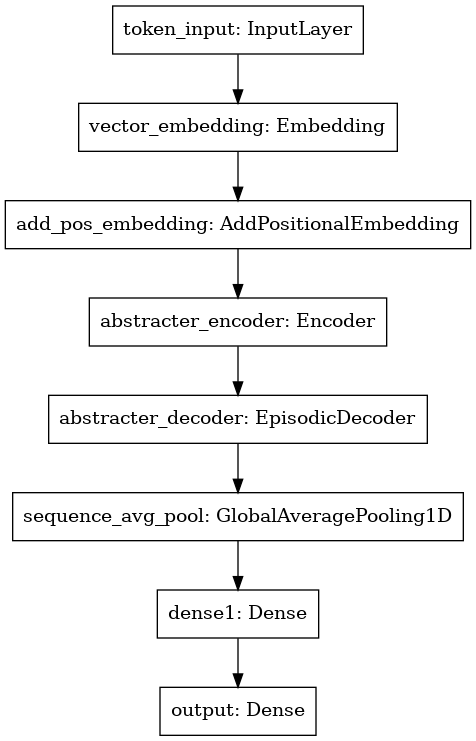

In [25]:
tf.keras.utils.plot_model(abstracter_model)

In [26]:
train_ds = create_tokenized_hand_clf_ds(seed=None)

run = wandb.init(project='Abstracter Hand Classification', group='Abstracter (Token Inputs)', save_code=True)

history = abstracter_model.fit(train_ds.batch(256), epochs=5, callbacks=create_callbacks())

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
2023-01-03 22:15:09.177917: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 22:15:09.178374: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-01-03 22:15:09.178575: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2023-01-03 22:15:09.180488: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

Epoch 1/5
40/40 [==============================] - 14s 98ms/step - loss: 0.7868 - acc: 0.7351 - precision: 0.7197 - recall: 0.7833 - auc: 0.8505


wandb: ERROR Can't save model in the h5py format. The model will be saved as W&B Artifacts in the SavedModel format.
2023-01-03 22:15:31.149208: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Adding directory to artifact (/kaggle/working/relational/wandb/run-20230103_221451-1yfwu4ai/files/model-best)... Done. 0.2s


Epoch 2/5
40/40 [==============================] - 3s 80ms/step - loss: 0.6949 - acc: 0.5043 - precision: 0.5088 - recall: 0.5439 - auc: 0.5035


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Adding directory to artifact (/kaggle/working/relational/wandb/run-20230103_221451-1yfwu4ai/files/model-best)... Done. 0.2s


Epoch 3/5
40/40 [==============================] - 4s 96ms/step - loss: 0.6966 - acc: 0.5025 - precision: 0.4973 - recall: 0.4113 - auc: 0.5018
Epoch 4/5
40/40 [==============================] - 4s 88ms/step - loss: 0.6950 - acc: 0.5027 - precision: 0.5050 - recall: 0.5515 - auc: 0.5010
Epoch 5/5
40/40 [==============================] - 4s 86ms/step - loss: 0.6970 - acc: 0.4963 - precision: 0.4881 - recall: 0.4622 - auc: 0.4938


In [27]:
test_ds = create_tokenized_hand_clf_ds(seed=42)
abstracter_model.evaluate(test_ds.batch(256), return_dict=True);
wrap_run(abstracter_model, test_ds)

40/40 [==============================] - 5s 82ms/step - loss: 0.7026 - acc: 0.4990 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7200


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67      4990
         1.0       0.00      0.00      0.00      5010

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000



acc,█▁▁▁▁
auc,█▁▁▁▁
epoch,▁▃▅▆█
loss,█▁▁▁▁
precision,█▂▁▂▁
recall,█▃▁▄▂
GFLOPS,0.00072
acc,0.4963
auc,0.49376
best_epoch,1
best_loss,0.69494


### Full Classifier as Card Encoder

In [28]:
inputs = layers.Input(shape=(hand_size,*card_image_shape), name='card_image_sequence')
pos_embedding_adder = AddPositionalEmbedding(name='add_pos_embedding')
abstracter_encoder = Encoder(num_layers=3, num_heads=2, dff=64, dropout_rate=0.1, name='abstracter_encoder')
symbolic = EpisodicDecoder(num_layers=3, num_heads=2, dff=64, use_pos_embedding=True,
                                   dropout_rate=0.1, name='abstracter_decoder')


x = layers.TimeDistributed(cnn_card_clf, name='encode_cards', trainable=False)(inputs)
x = pos_embedding_adder(x)

x = abstracter_encoder(x)

x = symbolic(x)

x = layers.GlobalAveragePooling1D(name='sequence_avg_pool')(x)
x = layers.Dense(64, activation='relu', name='dense1')(x) 
x = layers.Dense(2, activation='softmax', name='output')(x)

outputs = x

abstracter_model = tf.keras.Model(inputs, outputs, name='abstracter')
abstracter_model.summary()

abstracter_model.compile(loss=loss, optimizer=opt, metrics=metrics)

Model: "abstracter"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
card_image_sequence (InputLa [(None, 7, 178, 122, 3)]  0         
_________________________________________________________________
encode_cards (TimeDistribute (None, 7, 52)             142100    
_________________________________________________________________
add_pos_embedding (AddPositi (None, 7, 52)             0         
_________________________________________________________________
abstracter_encoder (Encoder) (None, 7, 52)             86928     
_________________________________________________________________
abstracter_decoder (Episodic (None, 7, 52)             153592    
_________________________________________________________________
sequence_avg_pool (GlobalAve (None, 52)                0         
_________________________________________________________________
dense1 (Dense)               (None, 64)                3

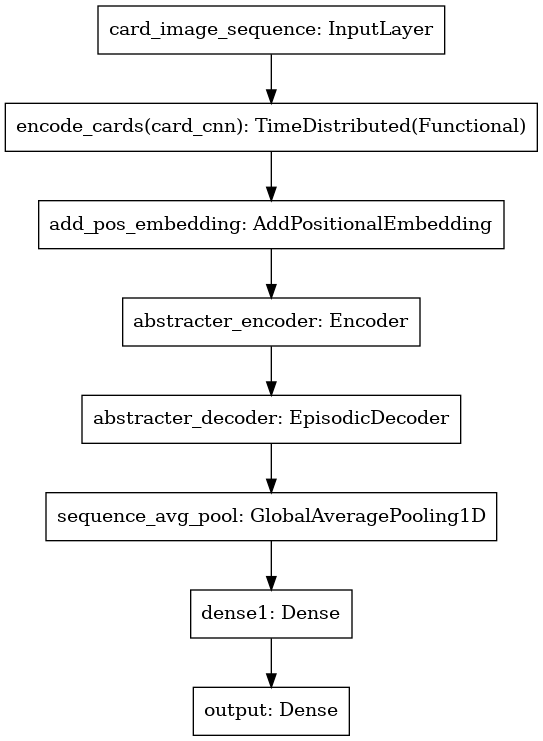

In [29]:
tf.keras.utils.plot_model(abstracter_model)

In [30]:
train_ds = create_img_hand_clf_ds(seed=None)

run = wandb.init(project='Abstracter Hand Classification', group='Abstracter (Image Input, Full Clf Encoder)', save_code=True)

history = abstracter_model.fit(train_ds.batch(256), epochs=5, callbacks=create_callbacks())

2023-01-03 22:17:39.959764: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 22:17:39.960190: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-01-03 22:17:39.960380: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2023-01-03 22:17:39.961150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 22:17:39.961709: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 22:17:39.962199: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

Epoch 1/5
40/40 [==============================] - 36s 642ms/step - loss: 0.5891 - acc: 0.5864 - precision: 0.6617 - recall: 0.3406 - auc: 0.7033


wandb: ERROR Can't save model in the h5py format. The model will be saved as W&B Artifacts in the SavedModel format.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Adding directory to artifact (/kaggle/working/relational/wandb/run-20230103_221722-wvjyjh8a/files/model-best)... Done. 0.1s


Epoch 2/5
40/40 [==============================] - 22s 533ms/step - loss: 0.3086 - acc: 0.8769 - precision: 0.8598 - recall: 0.8956 - auc: 0.9399


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Adding directory to artifact (/kaggle/working/relational/wandb/run-20230103_221722-wvjyjh8a/files/model-best)... Done. 0.1s


Epoch 3/5
40/40 [==============================] - 21s 525ms/step - loss: 0.1834 - acc: 0.9319 - precision: 0.9216 - recall: 0.9430 - auc: 0.9778


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Adding directory to artifact (/kaggle/working/relational/wandb/run-20230103_221722-wvjyjh8a/files/model-best)... Done. 0.1s


Epoch 4/5
40/40 [==============================] - 22s 538ms/step - loss: 0.1539 - acc: 0.9442 - precision: 0.9329 - recall: 0.9533 - auc: 0.9840


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Adding directory to artifact (/kaggle/working/relational/wandb/run-20230103_221722-wvjyjh8a/files/model-best)... Done. 0.1s


Epoch 5/5
40/40 [==============================] - 21s 521ms/step - loss: 0.1268 - acc: 0.9555 - precision: 0.9486 - recall: 0.9632 - auc: 0.9885


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Adding directory to artifact (/kaggle/working/relational/wandb/run-20230103_221722-wvjyjh8a/files/model-best)... Done. 0.1s


In [31]:
test_ds = create_img_hand_clf_ds(seed=42)
abstracter_model.evaluate(test_ds.batch(256), return_dict=True);
wrap_run(abstracter_model, test_ds)

40/40 [==============================] - 23s 516ms/step - loss: 0.0788 - acc: 0.9738 - precision: 0.9590 - recall: 0.9900 - auc: 0.9957
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97      4992
         1.0       0.96      0.99      0.97      5008

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



acc,▁▇███
auc,▁▇███
epoch,▁▃▅▆█
loss,█▄▂▁▁
precision,▁▆▇██
recall,▁▇███
GFLOPS,0.52549
acc,0.9555
auc,0.98854
best_epoch,4
best_loss,0.1268


### Classifier's Intermediate Encoder as Card Encoder

In [32]:
inputs = layers.Input(shape=(hand_size,*card_image_shape), name='card_image_sequence')
pos_embedding_adder = AddPositionalEmbedding(name='add_pos_embedding')
abstracter_encoder = Encoder(num_layers=3, num_heads=2, dff=64, dropout_rate=0.1, name='abstracter_encoder')
symbolic = EpisodicDecoder(num_layers=3, num_heads=2, dff=64, use_pos_embedding=True,
                                   dropout_rate=0.1, name='abstracter_decoder')


x = layers.TimeDistributed(card_encoder, name='encode_cards', trainable=False)(inputs)
x = pos_embedding_adder(x)

x = abstracter_encoder(x)

x = symbolic(x)

x = layers.GlobalAveragePooling1D(name='sequence_avg_pool')(x)
x = layers.Dense(64, activation='relu', name='dense1')(x) 
x = layers.Dense(2, activation='softmax', name='output')(x)

outputs = x

abstracter_model = tf.keras.Model(inputs, outputs, name='abstracter')
abstracter_model.summary()

abstracter_model.compile(loss=loss, optimizer=opt, metrics=metrics)

Model: "abstracter"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
card_image_sequence (InputLa [(None, 7, 178, 122, 3)]  0         
_________________________________________________________________
encode_cards (TimeDistribute (None, 7, 64)             138720    
_________________________________________________________________
add_pos_embedding (AddPositi (None, 7, 64)             0         
_________________________________________________________________
abstracter_encoder (Encoder) (None, 7, 64)             125376    
_________________________________________________________________
abstracter_decoder (Episodic (None, 7, 64)             225856    
_________________________________________________________________
sequence_avg_pool (GlobalAve (None, 64)                0         
_________________________________________________________________
dense1 (Dense)               (None, 64)                4

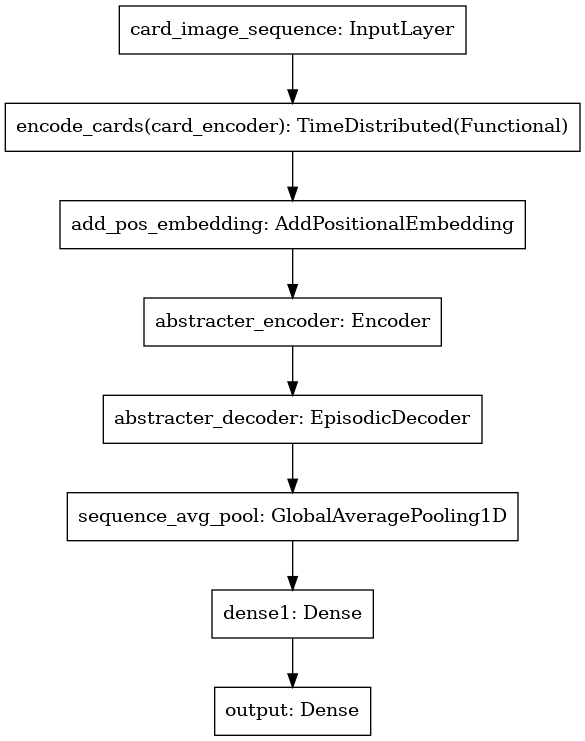

In [33]:
tf.keras.utils.plot_model(abstracter_model)

In [34]:
train_ds = create_img_hand_clf_ds(seed=None)

run = wandb.init(project='Abstracter Hand Classification', group='Abstracter (Image Input, Intermediate Encoder)', save_code=True)

history = abstracter_model.fit(train_ds.batch(256), epochs=5, callbacks=create_callbacks())

2023-01-03 22:25:23.727867: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 22:25:23.728473: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-01-03 22:25:23.728697: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2023-01-03 22:25:23.729638: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 22:25:23.730206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 22:25:23.730697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

Epoch 1/5
40/40 [==============================] - 36s 656ms/step - loss: 0.7456 - acc: 0.7384 - precision: 0.7296 - recall: 0.7550 - auc: 0.8588


wandb: ERROR Can't save model in the h5py format. The model will be saved as W&B Artifacts in the SavedModel format.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Adding directory to artifact (/kaggle/working/relational/wandb/run-20230103_222506-taxeuvrm/files/model-best)... Done. 0.1s


Epoch 2/5
40/40 [==============================] - 21s 523ms/step - loss: 0.6699 - acc: 0.5700 - precision: 0.5695 - recall: 0.5825 - auc: 0.6100


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Adding directory to artifact (/kaggle/working/relational/wandb/run-20230103_222506-taxeuvrm/files/model-best)... Done. 0.1s


Epoch 3/5
40/40 [==============================] - 21s 521ms/step - loss: 0.5372 - acc: 0.7402 - precision: 0.7308 - recall: 0.7665 - auc: 0.8039


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Adding directory to artifact (/kaggle/working/relational/wandb/run-20230103_222506-taxeuvrm/files/model-best)... Done. 0.1s


Epoch 4/5
40/40 [==============================] - 21s 518ms/step - loss: 0.4144 - acc: 0.8175 - precision: 0.8074 - recall: 0.8412 - auc: 0.8914


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Adding directory to artifact (/kaggle/working/relational/wandb/run-20230103_222506-taxeuvrm/files/model-best)... Done. 0.1s


Epoch 5/5
40/40 [==============================] - 21s 525ms/step - loss: 0.3730 - acc: 0.8434 - precision: 0.8369 - recall: 0.8517 - auc: 0.9130


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Adding directory to artifact (/kaggle/working/relational/wandb/run-20230103_222506-taxeuvrm/files/model-best)... Done. 0.1s


In [35]:
test_ds = create_img_hand_clf_ds(seed=42)
abstracter_model.evaluate(test_ds.batch(256), return_dict=True);
wrap_run(abstracter_model, test_ds)

40/40 [==============================] - 22s 505ms/step - loss: 0.2191 - acc: 0.9162 - precision: 0.8624 - recall: 0.9908 - auc: 0.9825
              precision    recall  f1-score   support

         0.0       0.99      0.85      0.91      4990
         1.0       0.87      0.99      0.93      5010

    accuracy                           0.92     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.93      0.92      0.92     10000



acc,▅▁▅▇█
auc,▇▁▅██
epoch,▁▃▅▆█
loss,█▇▄▂▁
precision,▅▁▅▇█
recall,▅▁▆██
GFLOPS,0.52553
acc,0.8434
auc,0.913
best_epoch,4
best_loss,0.37295


## "Symbolic Abstracter": Variant of Model with Symbol-Encoding Cross-Attention

- `SymbolicDecoder`: This is the variant where Q=D, K=E, V=D. The learned sequence of input vectors at the decoder can be thought of as abstract symbols, and their relations with the entities at the encoder (via cross-attention) can be thought of as bindings between the symbols and attributes of the input.

In [36]:
class SymbolicDecoder(tf.keras.layers.Layer):
    """Symbolic Decoder (Q=D, K=E, V=D)"""
    def __init__(self, num_layers, num_heads, dff, use_pos_embedding=True,
               dropout_rate=0.1, name='symbolic_decoder'):
        super(SymbolicDecoder, self).__init__(name=name)

        self.num_layers = num_layers
        self.num_heads = num_heads
        self.dff = dff
        self.use_pos_embedding = use_pos_embedding
        self.dropout_rate = dropout_rate

    def build(self, input_shape):

        _, self.sequence_length, self.d_model = input_shape

        # define the input-independent symbolic input vector sequence at the decoder
        normal_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
        self.decoder_symbol_sequence = tf.Variable(
            normal_initializer(shape=(self.sequence_length, self.d_model)),
            trainable=True)

        # layer which adds positional embedding (to be used on symbol sequence)
        if self.use_pos_embedding:
            self.add_pos_embedding = AddPositionalEmbedding()

        self.dropout = tf.keras.layers.Dropout(self.dropout_rate)

        self.dec_layers = [
            SymbolicDecoderLayer(d_model=self.d_model, num_heads=self.num_heads,
                         dff=self.dff, dropout_rate=self.dropout_rate)
            for _ in range(self.num_layers)]

        self.last_attn_scores = None

    def call(self, encoder_context):
        # symbol sequence is input independent, so use the same one for all computations in the given batch
        symbol_seq = tf.zeros_like(encoder_context) + self.decoder_symbol_sequence

        # add positional embedding
        if self.use_pos_embedding:
            symbol_seq = self.add_pos_embedding(symbol_seq)


        symbol_seq = self.dropout(symbol_seq)


        for i in range(self.num_layers):
            symbol_seq = self.dec_layers[i](symbol_seq, encoder_context)

#             self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        return symbol_seq

class SymbolicDecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1, name=None):
        super(SymbolicDecoderLayer, self).__init__(name=name)

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.symbolic_attention = SymbolicAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.self_attention(x=x)
        x = self.symbolic_attention(x=x, context=context)

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.symbolic_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.

        return x

class SymbolicAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=x ,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])

        x = self.layernorm(x)

        return x

### Token Inputs

In [37]:
inputs = layers.Input(shape=(7,), name='token_input')
token_embedder = layers.Embedding(52, 128, name='vector_embedding')
pos_embedding_adder = AddPositionalEmbedding(name='add_pos_embedding')
abstracter_encoder = Encoder(num_layers=3, num_heads=2, dff=64, dropout_rate=0.1, name='abstracter_encoder')
symbolic_decoder = SymbolicDecoder(num_layers=3, num_heads=2, dff=64, use_pos_embedding=True,
                                   dropout_rate=0.1, name='symbolic_decoder')


x = token_embedder(inputs)
x = pos_embedding_adder(x)

x = abstracter_encoder(x)

x = symbolic_decoder(x)

x = layers.GlobalAveragePooling1D(name='sequence_avg_pool')(x)
x = layers.Dense(64, activation='relu', name='dense1')(x) 
x = layers.Dense(2, activation='softmax', name='output')(x)

outputs = x

abstracter_model = tf.keras.Model(inputs, outputs, name='abstracter')
abstracter_model.summary()

abstracter_model.compile(loss=loss, optimizer=opt, metrics=metrics)

Model: "abstracter"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
token_input (InputLayer)     [(None, 7)]               0         
_________________________________________________________________
vector_embedding (Embedding) (None, 7, 128)            6656      
_________________________________________________________________
add_pos_embedding (AddPositi (None, 7, 128)            0         
_________________________________________________________________
abstracter_encoder (Encoder) (None, 7, 128)            447168    
_________________________________________________________________
symbolic_decoder (SymbolicDe (None, 7, 128)            844736    
_________________________________________________________________
sequence_avg_pool (GlobalAve (None, 128)               0         
_________________________________________________________________
dense1 (Dense)               (None, 64)                8

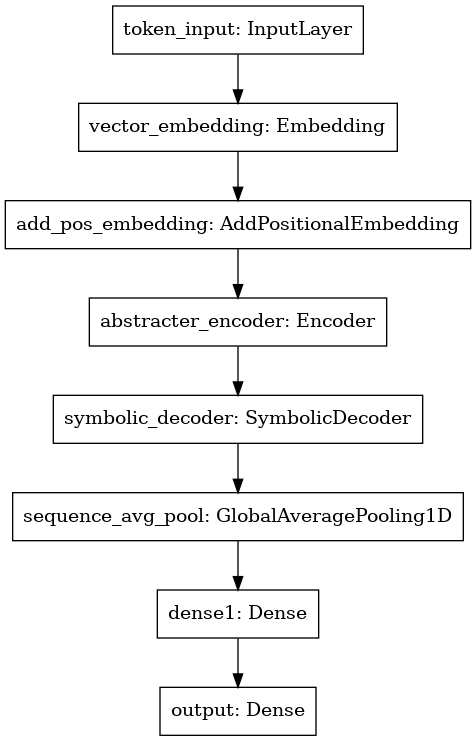

In [38]:
tf.keras.utils.plot_model(abstracter_model)

In [39]:
train_ds = create_tokenized_hand_clf_ds(seed=None)

run = wandb.init(project='Abstracter Hand Classification', group='Symbolic Abstracter (Token Inputs)', save_code=True)

history = abstracter_model.fit(train_ds.batch(256), epochs=5, callbacks=create_callbacks())

2023-01-03 22:31:20.691302: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 22:31:20.691790: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-01-03 22:31:20.691978: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2023-01-03 22:31:20.692801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 22:31:20.693289: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 22:31:20.693739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

Epoch 1/5
40/40 [==============================] - 15s 110ms/step - loss: 0.7861 - acc: 0.7089 - precision: 0.6940 - recall: 0.7545 - auc: 0.8234


wandb: ERROR Can't save model in the h5py format. The model will be saved as W&B Artifacts in the SavedModel format.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Adding directory to artifact (/kaggle/working/relational/wandb/run-20230103_223103-byl0bpti/files/model-best)... Done. 0.2s


Epoch 2/5
40/40 [==============================] - 3s 85ms/step - loss: 0.6948 - acc: 0.4959 - precision: 0.4933 - recall: 0.4679 - auc: 0.4992


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Adding directory to artifact (/kaggle/working/relational/wandb/run-20230103_223103-byl0bpti/files/model-best)... Done. 0.2s


Epoch 3/5
40/40 [==============================] - 4s 90ms/step - loss: 0.6943 - acc: 0.5041 - precision: 0.4977 - recall: 0.4770 - auc: 0.4994


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Adding directory to artifact (/kaggle/working/relational/wandb/run-20230103_223103-byl0bpti/files/model-best)... Done. 0.2s


Epoch 4/5
40/40 [==============================] - 4s 88ms/step - loss: 0.6939 - acc: 0.5063 - precision: 0.5086 - recall: 0.5407 - auc: 0.5110


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Adding directory to artifact (/kaggle/working/relational/wandb/run-20230103_223103-byl0bpti/files/model-best)... Done. 0.2s


Epoch 5/5
40/40 [==============================] - 4s 88ms/step - loss: 0.6944 - acc: 0.5049 - precision: 0.4969 - recall: 0.3801 - auc: 0.5005


In [40]:
test_ds = create_tokenized_hand_clf_ds(seed=42)
abstracter_model.evaluate(test_ds.batch(256), return_dict=True);
wrap_run(abstracter_model, test_ds)

40/40 [==============================] - 5s 79ms/step - loss: 0.6935 - acc: 0.5011 - precision: 0.5011 - recall: 1.0000 - auc: 0.5000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      4990
         1.0       0.50      1.00      0.67      5010

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000



acc,█▁▁▁▁
auc,█▁▁▁▁
epoch,▁▃▅▆█
loss,█▁▁▁▁
precision,█▁▁▂▁
recall,█▃▃▄▁
GFLOPS,0.00072
acc,0.5049
auc,0.50049
best_epoch,3
best_loss,0.69388


### Full Classifier as Card Encoder

In [41]:
inputs = layers.Input(shape=(hand_size,*card_image_shape), name='card_image_sequence')
pos_embedding_adder = AddPositionalEmbedding(name='add_pos_embedding')
abstracter_encoder = Encoder(num_layers=3, num_heads=2, dff=64, dropout_rate=0.1, name='abstracter_encoder')
symbolic = SymbolicDecoder(num_layers=3, num_heads=2, dff=64, use_pos_embedding=True,
                                   dropout_rate=0.1, name='abstracter_decoder')


x = layers.TimeDistributed(cnn_card_clf, name='encode_cards', trainable=False)(inputs)
x = pos_embedding_adder(x)

x = abstracter_encoder(x)

x = symbolic(x)

x = layers.GlobalAveragePooling1D(name='sequence_avg_pool')(x)
x = layers.Dense(64, activation='relu', name='dense1')(x) 
x = layers.Dense(2, activation='softmax', name='output')(x)

outputs = x

abstracter_model = tf.keras.Model(inputs, outputs, name='abstracter')
abstracter_model.summary()

abstracter_model.compile(loss=loss, optimizer=opt, metrics=metrics)

Model: "abstracter"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
card_image_sequence (InputLa [(None, 7, 178, 122, 3)]  0         
_________________________________________________________________
encode_cards (TimeDistribute (None, 7, 52)             142100    
_________________________________________________________________
add_pos_embedding (AddPositi (None, 7, 52)             0         
_________________________________________________________________
abstracter_encoder (Encoder) (None, 7, 52)             86928     
_________________________________________________________________
abstracter_decoder (Symbolic (None, 7, 52)             153592    
_________________________________________________________________
sequence_avg_pool (GlobalAve (None, 52)                0         
_________________________________________________________________
dense1 (Dense)               (None, 64)                3

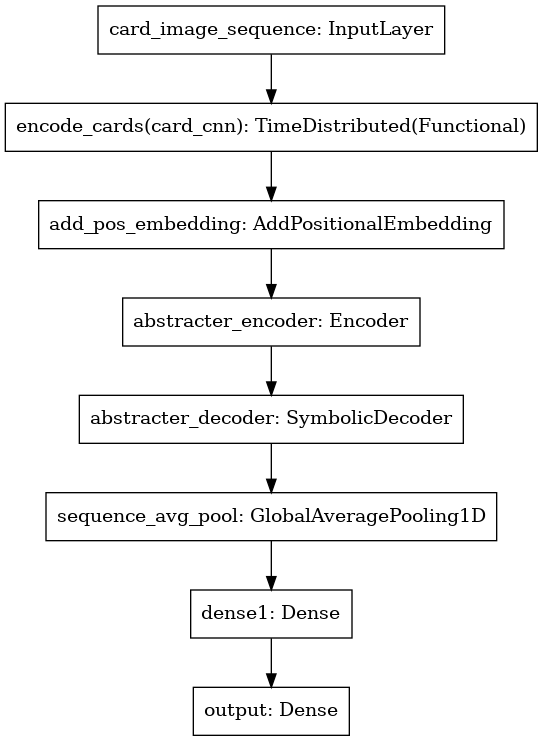

In [42]:
tf.keras.utils.plot_model(abstracter_model)

In [43]:
train_ds = create_img_hand_clf_ds(seed=None)

run = wandb.init(project='Abstracter Hand Classification', group='Symbolic Abstracte (Image Input, Full Clf Encoder)', save_code=True)

history = abstracter_model.fit(train_ds.batch(256), epochs=5, callbacks=create_callbacks())

2023-01-03 22:34:11.003502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 22:34:11.004042: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-01-03 22:34:11.004273: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2023-01-03 22:34:11.005237: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 22:34:11.005751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 22:34:11.006192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

Epoch 1/5
40/40 [==============================] - 37s 651ms/step - loss: 0.6873 - acc: 0.5373 - precision: 0.5226 - recall: 0.7855 - auc: 0.5645


wandb: ERROR Can't save model in the h5py format. The model will be saved as W&B Artifacts in the SavedModel format.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Adding directory to artifact (/kaggle/working/relational/wandb/run-20230103_223353-2atnxkdg/files/model-best)... Done. 0.2s


Epoch 2/5
40/40 [==============================] - 21s 518ms/step - loss: 0.5744 - acc: 0.7100 - precision: 0.6954 - recall: 0.7485 - auc: 0.7705


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Adding directory to artifact (/kaggle/working/relational/wandb/run-20230103_223353-2atnxkdg/files/model-best)... Done. 0.1s


Epoch 3/5
40/40 [==============================] - 22s 540ms/step - loss: 0.4337 - acc: 0.8074 - precision: 0.7982 - recall: 0.8315 - auc: 0.8807


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Adding directory to artifact (/kaggle/working/relational/wandb/run-20230103_223353-2atnxkdg/files/model-best)... Done. 0.1s


Epoch 4/5
40/40 [==============================] - 21s 513ms/step - loss: 0.3047 - acc: 0.8786 - precision: 0.8635 - recall: 0.9013 - auc: 0.9411


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Adding directory to artifact (/kaggle/working/relational/wandb/run-20230103_223353-2atnxkdg/files/model-best)... Done. 0.1s


Epoch 5/5
40/40 [==============================] - 22s 548ms/step - loss: 0.2045 - acc: 0.9250 - precision: 0.9099 - recall: 0.9422 - auc: 0.9724


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Adding directory to artifact (/kaggle/working/relational/wandb/run-20230103_223353-2atnxkdg/files/model-best)... Done. 0.1s


In [44]:
test_ds = create_img_hand_clf_ds(seed=42)
abstracter_model.evaluate(test_ds.batch(256), return_dict=True);
wrap_run(abstracter_model, test_ds)

40/40 [==============================] - 23s 526ms/step - loss: 0.1636 - acc: 0.9462 - precision: 0.9061 - recall: 0.9958 - auc: 0.9898
              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94      4990
         1.0       0.90      1.00      0.95      5010

    accuracy                           0.94     10000
   macro avg       0.95      0.94      0.94     10000
weighted avg       0.95      0.94      0.94     10000



acc,▁▄▆▇█
auc,▁▅▆▇█
epoch,▁▃▅▆█
loss,█▆▄▂▁
precision,▁▄▆▇█
recall,▂▁▄▇█
GFLOPS,0.52549
acc,0.925
auc,0.97242
best_epoch,4
best_loss,0.20453


### Classifier's Intermediate Encoder as Card Encoder

In [45]:
inputs = layers.Input(shape=(hand_size,*card_image_shape), name='card_image_sequence')
pos_embedding_adder = AddPositionalEmbedding(name='add_pos_embedding')
abstracter_encoder = Encoder(num_layers=3, num_heads=2, dff=64, dropout_rate=0.1, name='abstracter_encoder')
symbolic_decoder = SymbolicDecoder(num_layers=3, num_heads=2, dff=64, use_pos_embedding=True,
                                   dropout_rate=0.1, name='abstracter_decoder')


x = layers.TimeDistributed(card_encoder, name='encode_cards', trainable=False)(inputs)
x = pos_embedding_adder(x)

x = abstracter_encoder(x)

x = symbolic_decoder(x)

x = layers.GlobalAveragePooling1D(name='sequence_avg_pool')(x)
x = layers.Dense(64, activation='relu', name='dense1')(x) 
x = layers.Dense(2, activation='softmax', name='output')(x)

outputs = x

abstracter_model = tf.keras.Model(inputs, outputs, name='abstracter')
abstracter_model.summary()

abstracter_model.compile(loss=loss, optimizer=opt, metrics=metrics)

Model: "abstracter"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
card_image_sequence (InputLa [(None, 7, 178, 122, 3)]  0         
_________________________________________________________________
encode_cards (TimeDistribute (None, 7, 64)             138720    
_________________________________________________________________
add_pos_embedding (AddPositi (None, 7, 64)             0         
_________________________________________________________________
abstracter_encoder (Encoder) (None, 7, 64)             125376    
_________________________________________________________________
abstracter_decoder (Symbolic (None, 7, 64)             225856    
_________________________________________________________________
sequence_avg_pool (GlobalAve (None, 64)                0         
_________________________________________________________________
dense1 (Dense)               (None, 64)                4

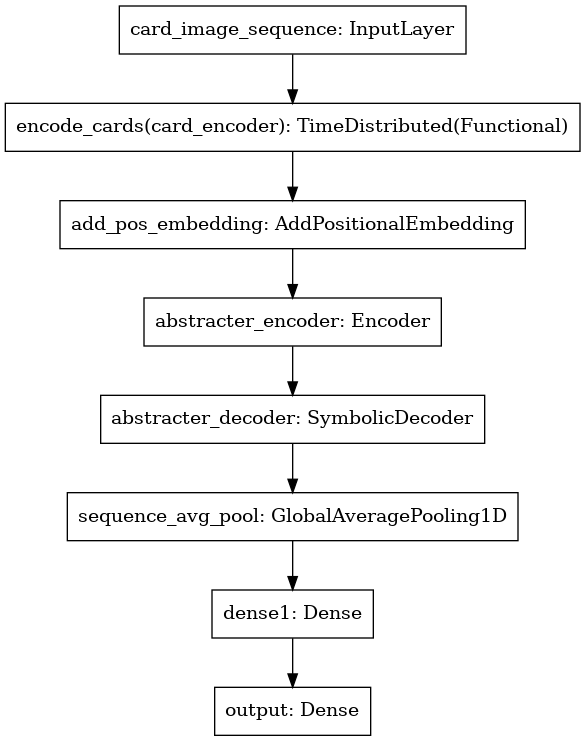

In [46]:
tf.keras.utils.plot_model(abstracter_model)

In [47]:
train_ds = create_img_hand_clf_ds(seed=None)

run = wandb.init(project='Abstracter Hand Classification', group='Symbolic Abstracter (Image Input, Intermediate Encoder)', save_code=True)

history = abstracter_model.fit(train_ds.batch(256), epochs=5, callbacks=create_callbacks())

2023-01-03 22:42:52.789462: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 22:42:52.789995: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-01-03 22:42:52.790201: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2023-01-03 22:42:52.791037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 22:42:52.791602: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 22:42:52.792080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

Epoch 1/5
40/40 [==============================] - 38s 641ms/step - loss: 0.7316 - acc: 0.7487 - precision: 0.7544 - recall: 0.7298 - auc: 0.8593


wandb: ERROR Can't save model in the h5py format. The model will be saved as W&B Artifacts in the SavedModel format.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Adding directory to artifact (/kaggle/working/relational/wandb/run-20230103_224235-2gmrhtth/files/model-best)... Done. 0.1s


Epoch 2/5
40/40 [==============================] - 21s 520ms/step - loss: 0.5820 - acc: 0.7008 - precision: 0.6839 - recall: 0.7332 - auc: 0.7625


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Adding directory to artifact (/kaggle/working/relational/wandb/run-20230103_224235-2gmrhtth/files/model-best)... Done. 0.2s


Epoch 3/5
40/40 [==============================] - 22s 534ms/step - loss: 0.5501 - acc: 0.7282 - precision: 0.7088 - recall: 0.7777 - auc: 0.7930


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Adding directory to artifact (/kaggle/working/relational/wandb/run-20230103_224235-2gmrhtth/files/model-best)... Done. 0.1s


Epoch 4/5
40/40 [==============================] - 21s 512ms/step - loss: 0.4539 - acc: 0.7904 - precision: 0.7839 - recall: 0.7947 - auc: 0.8690


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Adding directory to artifact (/kaggle/working/relational/wandb/run-20230103_224235-2gmrhtth/files/model-best)... Done. 0.1s


Epoch 5/5
40/40 [==============================] - 21s 525ms/step - loss: 0.3837 - acc: 0.8373 - precision: 0.8244 - recall: 0.8575 - auc: 0.9062


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Adding directory to artifact (/kaggle/working/relational/wandb/run-20230103_224235-2gmrhtth/files/model-best)... Done. 0.1s


In [48]:
test_ds = create_img_hand_clf_ds(seed=42)
abstracter_model.evaluate(test_ds.batch(256), return_dict=True);
wrap_run(abstracter_model, test_ds)

40/40 [==============================] - 22s 501ms/step - loss: 0.2651 - acc: 0.9025 - precision: 0.8447 - recall: 0.9868 - auc: 0.9776
              precision    recall  f1-score   support

         0.0       0.98      0.80      0.88      4990
         1.0       0.83      0.98      0.90      5010

    accuracy                           0.89     10000
   macro avg       0.91      0.89      0.89     10000
weighted avg       0.91      0.89      0.89     10000



acc,▃▁▂▆█
auc,▆▁▂▆█
epoch,▁▃▅▆█
loss,█▅▄▂▁
precision,▅▁▂▆█
recall,▁▁▄▅█
GFLOPS,0.52553
acc,0.8373
auc,0.90619
best_epoch,4
best_loss,0.38372
